## FK Engine

In [1]:
import numpy as np

def dh(a, alpha, d, theta):
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),               np.cos(alpha),              d],
        [0,              0,                           0,                          1]
    ])

def forward_kinematics(thetas):
    dh_params = [
        (0.0,  90, 0.3, thetas[0]),
        (0.4,   0, 0.0, thetas[1]),
        (0.3,   0, 0.0, thetas[2]),
        (0.0,  90, 0.2, thetas[3]),
        (0.0, -90, 0.0, thetas[4]),
        (0.0,   0, 0.1, thetas[5]),
    ]

    T = np.eye(4)
    for p in dh_params:
        T = T @ dh(*p)
    return T


In [2]:
def pose_from_T(T):
    x, y, z = T[0:3, 3]

    r = np.arctan2(T[2,1], T[2,2])
    p = np.arctan2(-T[2,0], np.sqrt(T[2,1]**2 + T[2,2]**2))
    y_ = np.arctan2(T[1,0], T[0,0])

    return np.array([x, y, z, r, p, y_])


In [ ]:
angles = [30, -20, 40, 10, 45, 0]
T = forward_kinematics(angles)
pose = pose_from_T(T)
print(pose)

# Output is :

# [ 0.65198071  0.06383147  0.23044265  1.95839301 -0.36136712 -0.33347317]

# x = 0.65 m
# y = 0.06 m
# z = 0.23 m
# roll  = 1.96 rad
# pitch = -0.36 rad
# yaw   = -0.33 rad



[ 0.65198071  0.06383147  0.23044265  1.95839301 -0.36136712 -0.33347317]


# ------------------------------------------------------------

## Dataset Generation for Deep Learning (100000 Data Points)

In [19]:
import numpy as np
# from fk import forward_kinematics, pose_from_T

N = 120000

X = []  # pose
Y = []  # angles (deg)

for _ in range(N):
    thetas = np.array([
        np.random.uniform(-90, 90),
        np.random.uniform(-90, 90),
        np.random.uniform(-90, 90),
        np.random.uniform(-180, 180),
        np.random.uniform(-90, 90),
        np.random.uniform(-180, 180),
    ])

    T = forward_kinematics(thetas)
    pose = pose_from_T(T)

    X.append(pose)
    Y.append(thetas)

X = np.array(X)
Y = np.array(Y)

# ---- sin / cos encoding ----
Y_rad = np.deg2rad(Y)
Y_sc = np.hstack([np.sin(Y_rad), np.cos(Y_rad)])

np.save("X_pose.npy", X)
np.save("Y_sc.npy", Y_sc)

print("Dataset:", X.shape, Y_sc.shape)


Dataset: (120000, 6) (120000, 12)


### XY Projection of Dataset

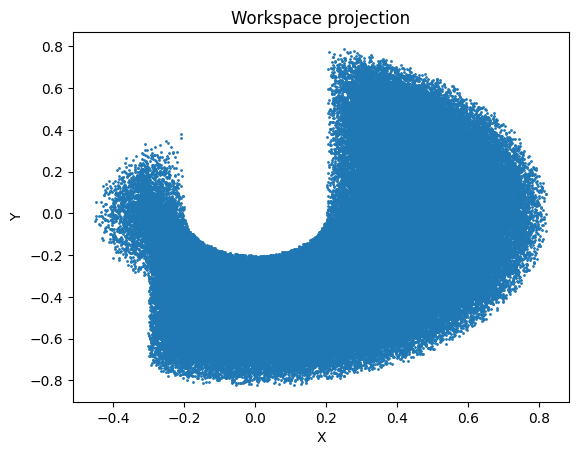

In [20]:
import matplotlib.pyplot as plt
X = np.load("X_pose.npy")

plt.scatter(X[:,0], X[:,1], s=1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Workspace projection")
plt.show()


### hollow inside 3D cloud 

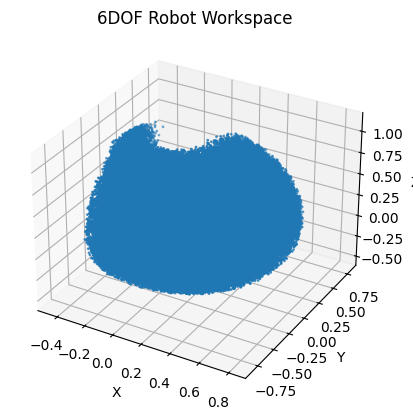

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.load("X_pose.npy")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], s=1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("6DOF Robot Workspace")

plt.show()


### Slice the Workspace in Z Axis

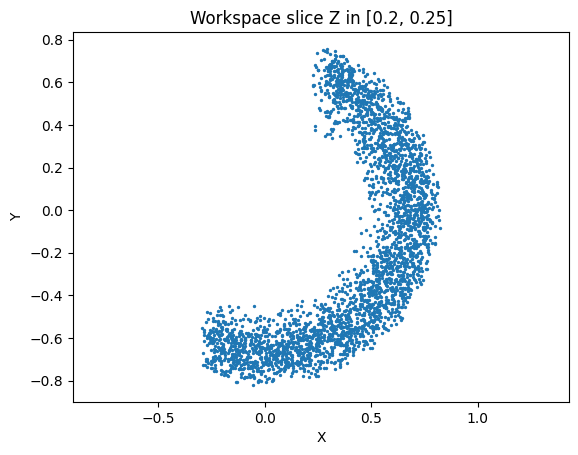

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load("X_pose.npy")

z_min = 0.2
z_max = 0.25

mask = (X[:,2] > z_min) & (X[:,2] < z_max)
slice_xy = X[mask]

plt.scatter(slice_xy[:,0], slice_xy[:,1], s=2)
plt.title(f"Workspace slice Z in [{z_min}, {z_max}]")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()


### Density Volume (3D inside view) Heatmap

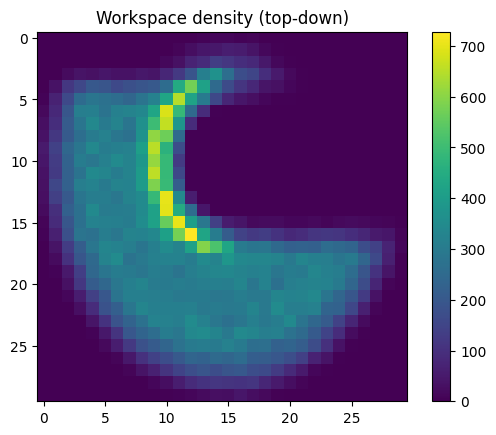

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load("X_pose.npy")

H, edges = np.histogramdd(X[:,0:3], bins=30)

plt.imshow(H.sum(axis=2))
plt.title("Workspace density (top-down)")
plt.colorbar()
plt.show()


## Deep Learning Inverse Kinematics Solver

#### Dataset Normalization

In [24]:
X = np.load("X_pose.npy")
Y = np.load("Y_sc.npy")

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
Xn = (X - X_mean) / X_std

# sin/cos does NOT need normalization
Yn = Y

np.save("X_norm.npy", [X_mean, X_std])


#### Neural Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu', input_shape=(6,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(12)   # sin/cos for 6 joints
])

model.compile(
    optimizer=Adam(1e-3),
    loss="mse"
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,028 (398.55 KB)

 Trainable params: 102,028 (398.55 KB)

 Non-trainable params: 0 (0.00 B)

#### Train

In [27]:
history = model.fit(
    Xn, Yn,
    validation_split=0.2,
    epochs=250,
    batch_size=512
)


Epoch 1/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2247 - val_loss: 0.2759
Epoch 2/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2242 - val_loss: 0.2746
Epoch 3/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2244 - val_loss: 0.2739
Epoch 4/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2247 - val_loss: 0.2744
Epoch 5/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2244 - val_loss: 0.2743
Epoch 6/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2241 - val_loss: 0.2753
Epoch 7/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2244 - val_loss: 0.2752
Epoch 8/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2239 - val_loss: 0.2744
Epoch 9/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2240 - val_loss: 0.2752
Epoch 10/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2241 - val_loss: 0.2754
Epoch 11/250
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2236 - val_loss: 0.2754
Epoch 12/250
188/188 ━━━━━━━━━

#### Test

In [28]:
import numpy as np

# random test
i = np.random.randint(len(X))
target_pose = X[i]

tp = (target_pose - X_mean) / X_std
pred_sc = model.predict(tp.reshape(1,-1))[0]

sin = pred_sc[:6]
cos = pred_sc[6:]

pred_angles = np.rad2deg(np.arctan2(sin, cos))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [29]:
T = forward_kinematics(pred_angles)
pose_pred = pose_from_T(T)

print("Target pose:", target_pose)
print("Predicted pose:", pose_pred)
print("Pose error:", target_pose - pose_pred)


Target pose: [ 0.47877264 -0.36870386 -0.07176612 -1.13513172 -0.00418253 -2.80751752]
Predicted pose: [ 0.48421468 -0.37649666 -0.17669175  1.8054063  -0.69120056 -0.19976898]
Pose error: [-0.00544204  0.0077928   0.10492563 -2.94053802  0.68701803 -2.60774854]
